In [7]:
import sys
import numpy as np
import xarray as xr
import numpy as np
import time
import glob
from scipy import integrate
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import cmocean
import cmocean as cmo
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from xgcm import Grid 
import datetime as dt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
ECCO_dir = base_dir + '/v5'
grid_dir= ECCO_dir + '/nctiles_grid/'
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [3]:
data_dir= ECCO_dir + '/nctiles_monthly'  
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['ETAN', 'PHIBOT'], years_to_load=range(1993,2002)).load()    
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))
# build grid object 
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances, XC distance from grid center point to center point, XG distance from grid egde (where u is defined) to grid edge (finite difference of values at XC will be placed here)
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
grid = Grid(ecco_monthly_ds, metrics=metrics)

loading files of  ETAN
loading files of  PHIBOT


In [4]:
# constants 
g = 9.81 
rho0 = 1029
# extract a single tile 
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
# -- pull out lats and lons
lons = ecco_monthly_ds.XC.sel(tile=tile_num)
lats = ecco_monthly_ds.YC.sel(tile=tile_num)
lons_g = ecco_monthly_ds.XG.sel(tile=tile_num)
lats_g = ecco_monthly_ds.YG.sel(tile=tile_num)

In [5]:
# bathymetry
dep = ecco_monthly_ds.Depth
dep = dep.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

In [6]:
# mask at the surface and total ocean area 
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)

In [23]:
# -- Gulf of Mexico Mask -- 
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
gulf_mask = xr.DataArray(
    data=ocean_mask.isel(tile=tile_num),
    dims=["j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.XC.i.data), j=(["j"], ecco_monthly_ds.XC.j.data),
        XC=(["j","i"], ecco_monthly_ds.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_monthly_ds.YC.isel(tile=tile_num).data), 
    ),
)
lon_w = -98; lon_e = -80; lat_s = 17; lat_n = 31; 
gulf_mask = gulf_mask.where(lons > lon_w, np.nan)
gulf_mask = gulf_mask.where(lons < lon_e, np.nan)
gulf_mask = gulf_mask.where(lats > lat_s, np.nan)
gulf_mask = gulf_mask.where(lats < lat_n, np.nan)
# subdivisions 
sub1 = np.where((lons > -81.75) & (lats > 25))
gulf_mask[np.arange(sub1[0][0],sub1[0][-1]), np.arange(sub1[1][0],sub1[1][-1])] = np.nan
gulf_mask = gulf_mask.where(lons < -81, np.nan)
sub2 = np.where((lons > -88) & (lats < 21.85))
gulf_mask[np.arange(sub2[0][0],sub2[0][-1]), np.arange(sub2[1][0],sub2[1][-1])] = np.nan
sub3 = np.where((lons > -84) & (lats < 23))
gulf_mask[np.arange(sub3[0][0],sub3[0][-1]), np.arange(sub3[1][0],sub3[1][-1])] = np.nan

da_gulf_mask = xr.DataArray(data=np.transpose(gulf_mask.data), dims=["lat","lon"],
                        coords=dict(
                            lon=(["lon"], np.nanmean(gulf_mask.XC,axis=1)),
                            lat=(["lat"], np.nanmean(gulf_mask.YC,axis=0)),
                        ),
                       )
gulf_area = np.nansum(gulf_mask*ecco_monthly_ds.rA.isel(tile=tile_num))

In [42]:
# steric height files
files0 = glob.glob('/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/' + '/rho_270_steric*.nc')
files0 = np.sort(files0)

In [24]:
# -- surface and layer areas -- 
h = dep.isel(tile=tile_num)                                 # depth 
A = ecco_monthly_ds.rA.isel(tile=tile_num)*gulf_mask        # cell area 
As = gulf_area 
# take layers as cell thicknesses 
imast = ecco_monthly_ds.drF.data.cumsum()[0:45]
# loop over each layer and compute area 
AA = []
for i in range(len(imast)):
    AA.append(np.nansum(A.where(h <= imast[i], np.nan)))    # area where depth less than or equal to current depth 
# turn into array 
AAi = np.array([AA.copy()])
AAi[0,0] = As                                               # first value is surface area 
AAi[0,1:] = As - np.array([AA[0:-1]])                       # area in layer i is total area minus area of depths shallower than i 
ii = imast
pbdeps = imast                                              # depths at bottom of each cell 
AAi = xr.DataArray(data=AAi[0,:], dims=["layer"],
    coords=dict(layer=(["layer"], np.arange(0,len(pbdeps))),),
)
print('percent of total area for each layer ' + str(np.round(100*(AAi.data/gulf_area),1)))

percent of total area for each layer [100.   96.4  91.3  86.6  82.5  78.7  75.7  74.2  72.9  72.   71.4  70.4
  69.5  69.   68.3  68.3  67.   66.4  65.2  64.4  63.6  62.7  61.8  61.2
  60.3  59.3  58.   56.6  55.5  53.9  52.2  50.5  49.1  47.9  46.4  44.3
  42.4  40.6  37.2  34.8  32.2  28.3  23.8  12.7   0.1]


In [48]:
# prep for redist model (layer thickness)
# gulf mask applied here so all density values are nan-ed out elsewhere 
v_cell_t = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF            # actual layer thicknesses 
v_cell_t = v_cell_t.rename({'k': 'layer'})
v_cell_t = v_cell_t*gulf_mask
v_cell_z = ecco_grid.Z[0:45]                                            # depth of vertical cell center 

In [ ]:
## -- BEGIN MASTER LOOP HERE -- 

In [68]:
# loop over desired decade 
periods = np.arange(1993,2009)
tp = 10 

In [69]:
prediction = np.nan*np.ones((len(periods),len(v_cell_z)))
GOM_mean_obp_trend = np.nan*np.ones(len(periods))
GOM_anom_obp_trend = np.nan*np.ones((len(periods),np.shape(ecco_monthly_ds.PHIBOT.isel(tile=tile_num,time=0))[0],np.shape(ecco_monthly_ds.PHIBOT.isel(tile=tile_num,time=0))[1]))
for master in range(14,16):
    # --------------------------------------
    # -- RELOAD ECCO over desired years -- 
    ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['PHIBOT'], years_to_load=range(periods[master],periods[master]+tp)).load()    
    ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))
    metrics = {('X',): ['dxC', 'dxG'], ('Y',): ['dyC', 'dyG'], ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw']}
    grid = Grid(ecco_monthly_ds, metrics=metrics)
    # --- OBP ---  
    obp_cor = 1029*(ecco_monthly_ds.PHIBOT + g*dep) # calculate OBP following ECCO code 
    OBP_global_mean_mon = (obp_cor*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
    obp_mgm = obp_cor - OBP_global_mean_mon      # subtract global spatial mean time series 
    obp_anom = obp_mgm - obp_mgm.mean(dim='time')  # subtract time mean at each point 
    pobp = obp_anom.polyfit(dim='time', deg=1)
    # --------------------------------------
    # -- LLC270 (load steric height and steric pressure already computed) -- 
    si = np.where(files0 == '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_' + str(periods[master]) + '.nc')[0][0]
    files = files0[si:si+tp]
    print(files[0])
    print(files[-1])
    count = 0
    for i in range(len(files)):
        this_file = xr.open_dataset(files[i]);
        if count < 1:
            ds_den_r = this_file.rho
        else:
            ds_den_r = xr.concat([ds_den_r, this_file.rho], dim="time")
        count = count + 1
    
    # ---------------------------------
    # -- extract linear OBP trend (from OBP anomaly (subtracted global mean time series and local time mean)
    # -- remove GOM mean trend (import of mass into basin)
    fitloc = pobp.polyfit_coefficients.isel(degree=0).isel(tile=tile_num)*1e9*60*60*24*365/g/rho0
    mean_gulf_trend = np.nansum(fitloc*gulf_mask*ecco_monthly_ds.rA.isel(tile=tile_num))/gulf_area 
    gulf_t_obp = fitloc*gulf_mask
    gulf_a_obp = gulf_t_obp - mean_gulf_trend
    print('mean gulf obp trend = ' + str(mean_gulf_trend))

    # ---------------------------------
    # -- Run Landerer Model --
    time0 = time.time()
    delta_pb_total = np.nan*np.ones((np.shape(ds_den_r)[0],len(pbdeps)))
    # -- main loop -- 
    print('begin redistribution est.')
    for tt in range(np.shape(ds_den_r)[0]):                                 # loop over all times 
        for m in range(0,45):                                               # loop over all layers 
            this_i = np.where(-1*v_cell_z <= -1*v_cell_z[m])[0]                   # all depths shallower than depth i 
            this_i = this_i[-1]                                             # deepest index (the layer we care about in this loop)   
            below_i = np.arange(this_i+1,len(v_cell_z))
            above_i = np.arange(0,this_i+1)
    
            # -- for each layer, multiply rho_prime by layer thickness, then average across basin 
            below = (1/rho0)*( (AAi.isel(layer=below_i)/As)*\
                               (v_cell_t.isel(layer=below_i)*\
                               -1*ds_den_r[tt].isel(layer=below_i)).mean(dim=['j','i'])).sum(dim='layer')
            above = (1/rho0)*((As/AAi.isel(layer=above_i) - 1)*(AAi.isel(layer=above_i)/As)*\
                               (v_cell_t.isel(layer=above_i)*\
                               -1*ds_den_r[tt].isel(layer=above_i)).mean(dim=['j','i'])).sum(dim='layer')
            delta_pb_total[tt,m] = below.data - above.data

    # -- place in data array         
    deltapbz_total = xr.DataArray(data=np.transpose(delta_pb_total), dims=["zi","time"],
                            coords=dict(
                                zi=(["zi"], ds_den_r.layer.data[0:len(pbdeps)]),
                                time=(["time"], ecco_monthly_ds.time.data),
                            ),
                           )
    # did stuff
    elapsed = time.time() - time0
    print('runtime = ' + str(elapsed/60) + ' minutes') # in seconds 

    # -- remove time mean from landerer predicted delta pb and fit linear trend at each depth 
    test = (deltapbz_total - deltapbz_total.mean(dim=['time']))
    p_test = test.polyfit(dim='time', deg=1)
    p_test = (p_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365
    prediction[master,:] = p_test
    GOM_mean_obp_trend[master] = mean_gulf_trend
    GOM_anom_obp_trend[master,:,:] = gulf_a_obp.data

loading files of  PHIBOT
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2007.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2016.nc
mean gulf obp trend = 0.0029173976177216216
begin redistribution est.
runtime = 5.801941748460134 minutes
loading files of  PHIBOT
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2008.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2017.nc
mean gulf obp trend = 0.0030362258595405833
begin redistribution est.
runtime = 5.698767097791036 minutes


In [55]:
np.shape(gulf_a_obp.data)

(270, 270)

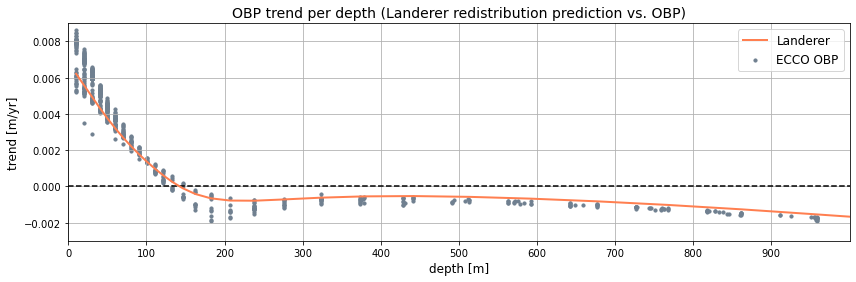

In [70]:
f,ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([0,3000],[0, 0], color='k', linewidth=1.5, linestyle='--')

ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_obp, s=10, color='#708090',label='ECCO OBP'); 
ax.plot(pbdeps, p_test, color='#FF7F50', linewidth=2, label='Landerer')

ax.set_xlim([0,1000]); ax.set_xticks(np.arange(0,1000,100)); ax.set_xlabel('depth [m]',fontsize=12)
ax.set_ylim([-0.003, 0.009]); ax.set_ylabel('trend [m/yr]',fontsize=12)
ax.grid(); ax.set_title('OBP trend per depth (Landerer redistribution prediction vs. OBP)',fontsize=14); 
ax.legend(fontsize=12)
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/landerer_predicted_trend.jpg', dpi=250)

Text(0.5, 1.0, 'ECCO: OBP Trend')

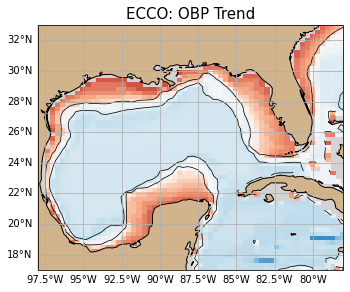

In [47]:
lon_w = -98; lon_e = -78; lat_s = 17; lat_n = 33; 
colMap = plt.get_cmap('RdBu_r')
cmin = mean_gulf_trend - 0.01
cmax = mean_gulf_trend + 0.01
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)

f, ax = plt.subplots(1,1,figsize=(6,4.5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cc = ax.pcolor(lons, lats, pobp.polyfit_coefficients.sel(tile=tile_num,degree=1)*1e9*60*60*24*365/g/rho0, transform=ccrs.PlateCarree(),cmap=colMap,vmin=cmin,vmax=cmax); 
ax.contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])
ax.set_facecolor('#D3D3D3'); ax.grid(); 
ax.set_title(r'ECCO: OBP Trend',fontsize=15)

In [146]:
dep_m = (dep.isel(tile=tile_num)*gulf_mask).data
dep_list = np.reshape(dep_m,(np.shape(dep_m)[0]*np.shape(dep_m)[1]))

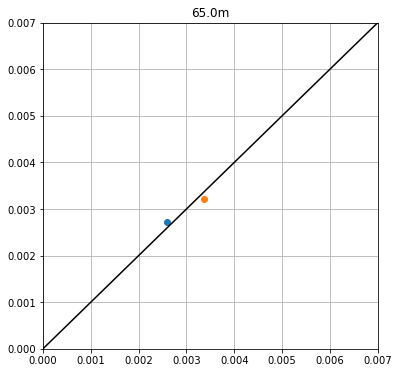

In [156]:
t_d_i = 6
f, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot([0,1],[0,1],color='k')
for jj in range(14,16):
    obp_anom_list = np.reshape(GOM_anom_obp_trend[jj,:,:],(np.shape(dep_m)[0]*np.shape(dep_m)[1]))
    this_dep = -1*v_cell_z[t_d_i].data
    this_band = np.where((dep_list > (this_dep-15)) & (dep_list < (this_dep+15)))
    band_obp_trend = obp_anom_list[this_band]
    ax.scatter(np.nanmean(band_obp_trend), prediction[jj,d_i])
ax.set_ylim([0,0.007])
ax.set_xlim([0,0.007])
ax.set_title(str(-1*v_cell_z[t_d_i].data) + 'm')
ax.grid()

In [151]:
obp_anom_list[this_band]

array([0.0054046 , 0.00654107, 0.00661048, 0.00643634, 0.00610942,
       0.00646027, 0.00550677, 0.0055935 , 0.00557942, 0.00537182,
       0.00545529, 0.00626722, 0.00534996, 0.00617443, 0.00525371,
       0.00606094, 0.00521745, 0.00602493, 0.00521115, 0.00601565,
       0.00598837, 0.00603656, 0.00596242, 0.00594188, 0.00593699,
       0.00593925, 0.00605252, 0.00595065, 0.00593679, 0.00529712,
       0.00597303, 0.00594721, 0.00509733, 0.00610897, 0.00594883,
       0.00477463, 0.00511048, 0.00522902, 0.00532964, 0.00535902,
       0.00593825, 0.00493865, 0.005286  , 0.00536391, 0.00532483,
       0.00532866, 0.00612948, 0.00614995, 0.00616431, 0.00616787,
       0.00508459, 0.0060966 , 0.00633463, 0.00634982, 0.00508848,
       0.00475697, 0.00527879, 0.00629202, 0.00498163, 0.00552833,
       0.00649661, 0.00511059, 0.00511235, 0.00620628, 0.00514597,
       0.00450673, 0.00517019, 0.00631289, 0.00529748, 0.00648242,
       0.00553534, 0.00619591, 0.00569157, 0.00528112, 0.00630